In [1]:
import os

os.environ["BRASA_DATA_PATH"] = "/mnt/d/brasa"

In [2]:
import numpy as np

In [3]:
import sys
sys.path.append('..')

from datetime import datetime

import pandas as pd
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow

import brasa

In [4]:
etfs = pd.read_csv("etfs-listados-20231014.csv", encoding="latin1", sep=";")

In [5]:
etfs["symbol"] = etfs["Código"] + "11"
etfs = etfs.set_index("symbol")

In [6]:
brasa.describe("b3-cotahist")

regtype: unicode
refdate: datetime
bdi_code: int64
symbol: unicode
instrument_market: int64
corporation_name: unicode
specification_code: unicode
days_to_settlement: float64
trading_currency: unicode
open: float64
high: float64
low: float64
average: float64
close: float64
best_bid: float64
best_ask: float64
trade_quantity: int64
traded_contracts: int64
volume: float64
strike_price: float64
strike_price_adjustment_indicator: unicode
maturity_date: datetime
allocation_lot_size: float64
strike_price_in_points: float64
isin: unicode
distribution_id: int64


In [17]:
etfs_table = brasa.get_dataset("b3-cotahist")\
    .filter(pc.field("symbol").isin(etfs.index))\
    .filter(pc.field("refdate") >= datetime(2023, 1, 1))\
    .scanner(columns=["refdate", "symbol", "volume", "close"])\
    .to_table()\
    .group_by("symbol")\
    .aggregate([([], "count_all"), ("volume", "mean")])\
    .sort_by([("volume_mean", "descending")])\
    .to_pandas()
etfs_table.style.format({"volume_mean": "{:,.0f}"})

,symbol,count_all,volume_mean
0,BOVA11,471,"691,202,345"
1,SMAL11,471,"261,360,518"
2,BOVV11,471,"213,858,622"
3,IVVB11,471,"81,648,847"
4,HASH11,471,"18,497,804"
5,BBOV11,471,"15,543,534"
6,NASD11,471,"12,169,023"
7,GOLD11,471,"11,122,123"
8,BOVX11,471,"9,706,155"
9,FIND11,470,"7,884,790"


In [22]:
etfs_table[etfs_table.volume_mean > 100_000].symbol

0     BOVA11
1     SMAL11
2     BOVV11
3     IVVB11
4     HASH11
5     BBOV11
6     NASD11
7     GOLD11
8     BOVX11
9     FIND11
10    SPXI11
11    SMAC11
12    DIVO11
13    BOVB11
14    BITH11
15    QBTC11
16    XINA11
17    PIBB11
18    ETHE11
19    USAL11
20    IBOB11
21    UTEC11
22    TECK11
23    WRLD11
24    NDIV11
25    ACWI11
26    EURP11
27    ESGU11
28    MATB11
29    QETH11
30    BCIC11
31    NSDV11
32    BTEK11
33    BDEF11
34    TRIG11
35    ESGD11
36    SVAL11
37    BITI11
38    BREW11
39    GENB11
40    GOVE11
41    USTK11
42    ALUG11
43    BRAX11
44    ESGE11
45    BMMT11
46    HTEK11
47    JOGO11
48    URET11
49    MILL11
50    BOVS11
51    WEB311
52    XFIX11
53    DEFI11
54    AGRI11
55    CMDB11
56    ELAS11
57    BBOI11
Name: symbol, dtype: object

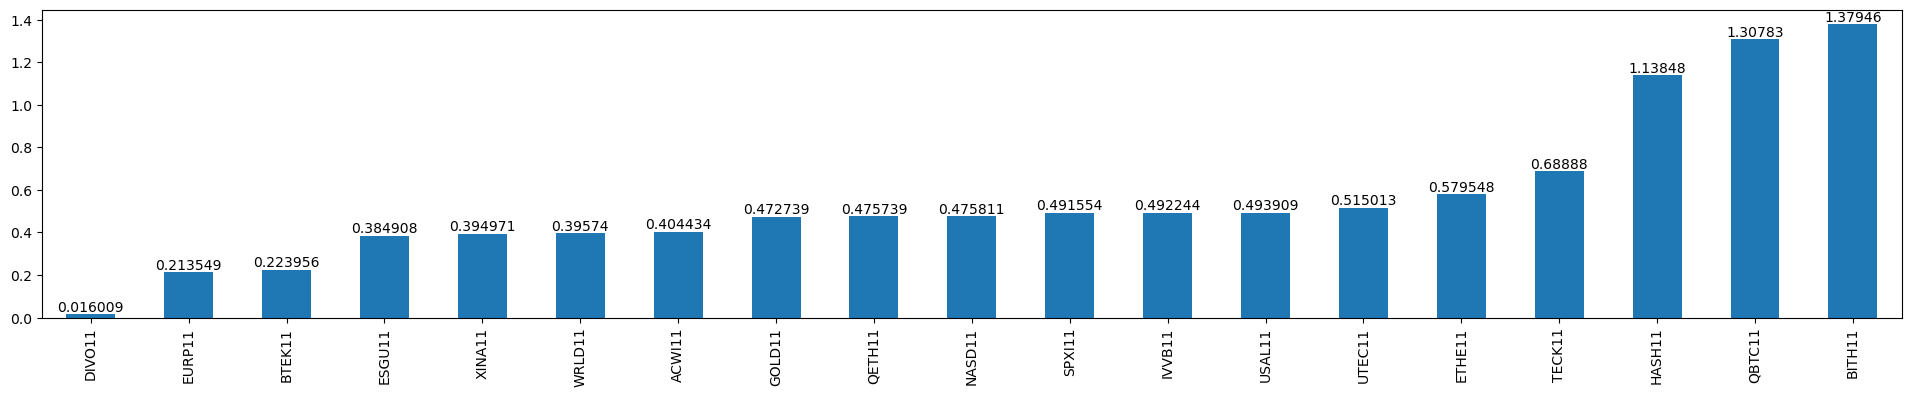

In [24]:
year = 2024
rets = brasa.get_returns(etfs_table[etfs_table.volume_mean > 500_000].symbol, start=datetime(year, 1, 1), end=datetime(year, 12, 31))
_rets = np.exp(rets.sum()) - 1
ax = (_rets[_rets > 0]).sort_values().plot.bar(figsize=(24, 4))
for container in ax.containers:
    ax.bar_label(container)

In [9]:
symbols = ["PIBB11", "DIVO11", "SMAL11", "XINA11", "GOLD11", "HASH11", "WRLD11", "ACWI11", "QBTC11", "ALUG11", "XFIX11", "IVVB11"]
year = 2024
rets = brasa.get_returns(symbols, start=datetime(year, 1, 1), end=datetime(year, 12, 31))

In [11]:
xx = rets.corr()
idx = xx.loc["IVVB11",:].sort_values().index
xx.loc[idx, idx].style.background_gradient(cmap='coolwarm')

,SMAL11,DIVO11,PIBB11,XFIX11,XINA11,QBTC11,HASH11,GOLD11,ALUG11,WRLD11,ACWI11,IVVB11
SMAL11,1.000000,0.723809,0.746647,0.127468,0.048894,0.028112,0.010144,-0.227826,-0.084237,-0.126050,-0.173448,-0.247336
DIVO11,0.723809,1.000000,0.834373,0.043141,0.253881,-0.043247,-0.051187,-0.131610,-0.045326,-0.045226,-0.113953,-0.217703
PIBB11,0.746647,0.834373,1.000000,0.035602,0.208954,0.006874,0.002153,-0.159607,-0.090323,-0.061957,-0.096383,-0.192270
XFIX11,0.127468,0.043141,0.035602,1.000000,-0.020693,0.077079,0.063287,0.080834,0.066388,0.045395,0.061503,0.054426
XINA11,0.048894,0.253881,0.208954,-0.020693,1.000000,0.118852,0.092342,0.163537,-0.004495,0.179707,0.212934,0.088890
QBTC11,0.028112,-0.043247,0.006874,0.077079,0.118852,1.000000,0.931904,0.094337,0.211742,0.240395,0.281689,0.265851
HASH11,0.010144,-0.051187,0.002153,0.063287,0.092342,0.931904,1.000000,0.123308,0.223394,0.295471,0.348984,0.326771
GOLD11,-0.227826,-0.131610,-0.159607,0.080834,0.163537,0.094337,0.123308,1.000000,0.430465,0.469252,0.460295,0.441935
ALUG11,-0.084237,-0.045326,-0.090323,0.066388,-0.004495,0.211742,0.223394,0.430465,1.000000,0.603667,0.533849,0.536080
WRLD11,-0.126050,-0.045226,-0.061957,0.045395,0.179707,0.240395,0.295471,0.469252,0.603667,1.000000,0.831135,0.808177


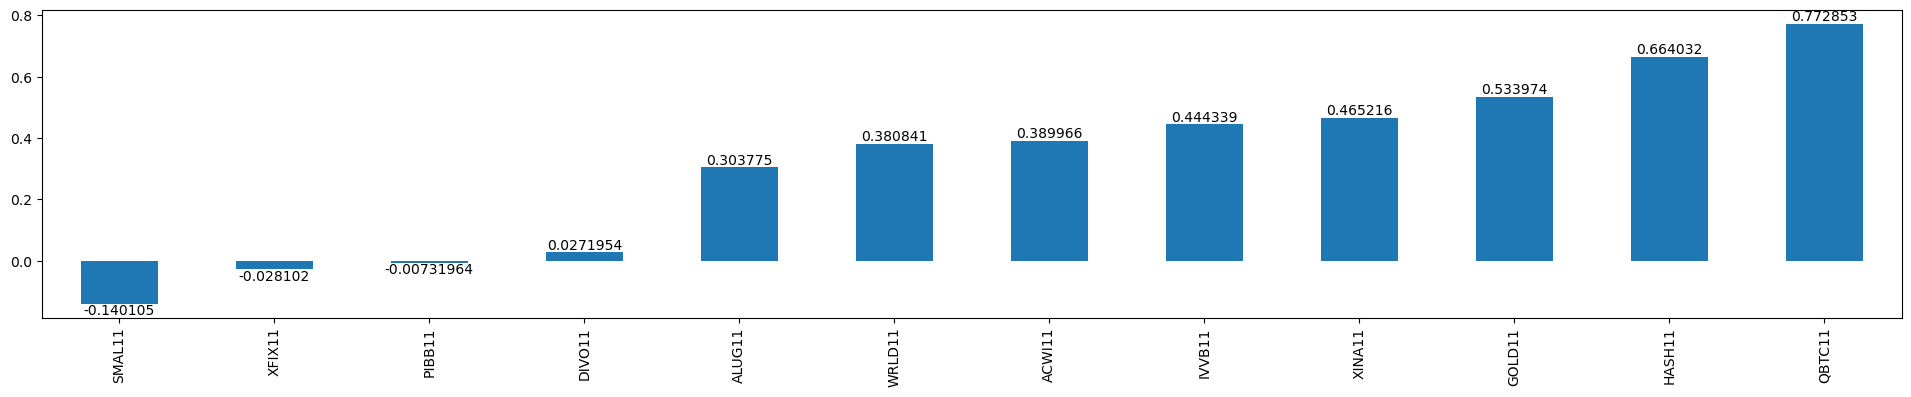

In [12]:
ax = (np.exp(rets.sum()) - 1).sort_values().plot.bar(figsize=(24, 4))
for container in ax.containers:
    ax.bar_label(container)

<Axes: >

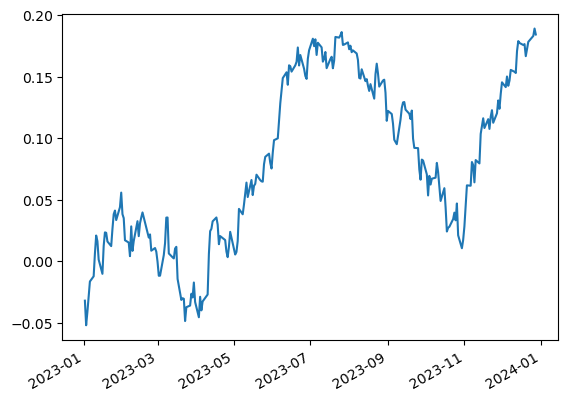

In [12]:
symbols = [
    "ABEV3",
    "ARZZ3",
    "B3SA3",
    "BBAS3",
    "EGIE3",
    "EZTC3",
    "INTB3",
    "ITSA4",
    "PSSA3",
    "WEGE3",
]

positions = pd.Series([
    1300.0,
    300.0,
    1000.0,
    400.0,
    800.0,
    800.0,
    500.0,
    1732.5,
    1000.0,
    100.0,
], index=symbols)

df = brasa.get_dataset("b3-cotahist")\
    .filter(pc.field("symbol").isin(symbols))\
    .filter(pc.field("refdate") == datetime(2024, 1, 5))\
    .scanner(columns=["refdate", "symbol", "close"])\
    .to_table()\
    .to_pandas()

# df["close"] = df["close"]*positions
# df.style.format({"close": "{:,.2f}", "volume": "{:,.2f}"})

portfolio = df.pivot(index="refdate", columns="symbol", values="close") * positions

weights = portfolio / portfolio.sum(axis=1).iloc[0]
weights = weights.iloc[0]
weights.name = None

rets = brasa.get_returns(symbols, start=datetime(2023, 1, 1))

portfolio_returns = (rets * weights).sum(axis=1)

portfolio_returns.cumsum().plot()

In [13]:
display(rets.sum())
(rets.sum() * weights).sum()

ABEV3   -0.012539
ARZZ3   -0.166516
B3SA3    0.123959
BBAS3    0.552002
EGIE3    0.245589
EZTC3    0.341967
INTB3   -0.303480
ITSA4    0.303417
PSSA3    0.257950
WEGE3   -0.026062
dtype: float64

0.18423133236372624

In [14]:
rets.std() * np.sqrt(252)

ABEV3    0.209078
ARZZ3    0.422400
B3SA3    0.354826
BBAS3    0.243919
EGIE3    0.170192
EZTC3    0.446794
INTB3    0.390231
ITSA4    0.212334
PSSA3    0.227108
WEGE3    0.253347
dtype: float64

<Axes: >

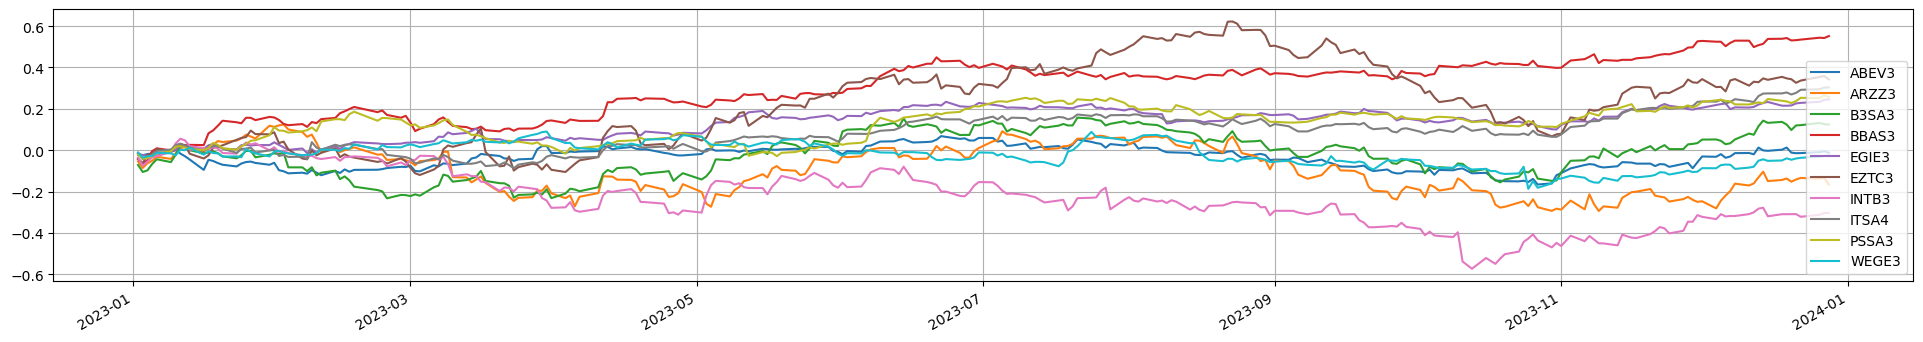

In [15]:
rets.cumsum().plot(grid=True, figsize=(24, 4))

In [16]:
portfolio_returns.std() * np.sqrt(252)

0.18031483124763506

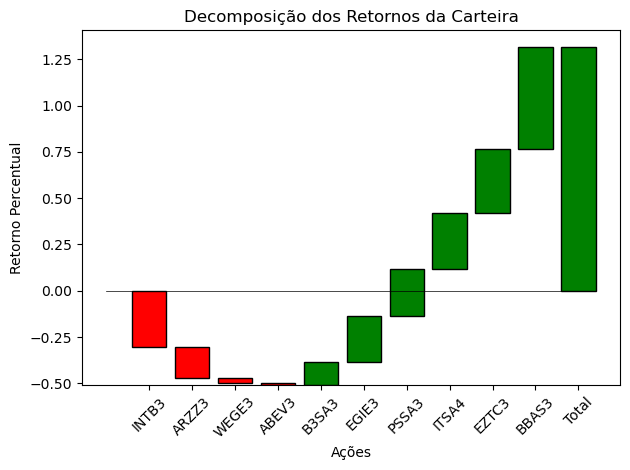

In [17]:
import matplotlib.pyplot as plt

# Exemplo de dados
retornos = rets.sum().sort_values()
acoes = retornos.index
retorno_carteira = rets.sum().sum()

# Cálculo do início de cada barra
start = 0
starts = [start]
for retorno in retornos[:-1]:
    start += retorno
    starts.append(start)

cores = ['green' if retorno >= 0 else 'red' for retorno in retornos]

# Criação do gráfico waterfall
fig, ax = plt.subplots()
for i, (acao, retorno, cor) in enumerate(zip(acoes, retornos, cores)):
    ax.bar(acao, retorno, bottom=starts[i], color=cor, edgecolor='black')

# Adicionar o retorno total com uma cor específica se for positivo ou negativo
cor_total = 'green' if retorno_carteira >= 0 else 'red'
ax.bar('Total', retorno_carteira, bottom=0, edgecolor='black', color=cor_total)

# Adiciona linhas para melhor visualização
ax.plot([-1, len(acoes)], [0, 0], color='black', linewidth=0.5)

# Configurações adicionais
ax.set_title('Decomposição dos Retornos da Carteira')
ax.set_ylabel('Retorno Percentual')
ax.set_xlabel('Ações')
plt.xticks(rotation=45)  # Rotação dos labels no eixo x para melhor visualização
plt.tight_layout()
plt.show()


In [18]:
symbols = ["ACWI11", "XFIX11", "QBTC11"]
df = brasa.get_dataset("b3-cotahist")\
    .filter(pc.field("symbol").isin(symbols))\
    .filter(pc.field("refdate") == datetime(2023, 12, 28))\
    .scanner(columns=["refdate", "symbol", "volume", "close"])\
    .to_table()\
    .to_pandas()

rets = brasa.get_returns(symbols, start=datetime(2023, 1, 1))
df["close"] = df["close"]*100
df.style.format({"close": "{:,.2f}", "volume": "{:,.2f}"})

,refdate,symbol,volume,close
0,2023-12-28 00:00:00,ACWI11,"123,072.32","1,025.00"
1,2023-12-28 00:00:00,QBTC11,"2,368,871.93","1,338.00"
2,2023-12-28 00:00:00,XFIX11,"70,553.75","1,178.00"


In [19]:
display(rets.sum())
portfolio_returns.sum()

ACWI11    0.102258
QBTC11    0.900195
XFIX11    0.153848
dtype: float64

0.1842313323637263

In [20]:
portfolio_returns.name = "portfolio"

In [21]:
_rets = pd.concat([portfolio_returns, rets], axis=1)

In [25]:
amount = 8950.75

perc = 1 - amount / portfolio.sum(axis=1).iloc[0]
perc_max = amount / portfolio.sum(axis=1).iloc[0]
perc_min = 0.01

In [26]:
from scipy.optimize import minimize

# Dados de entrada
retornos_esperados = _rets.sum().values
volatilidades = _rets.std().values
correlacoes = _rets.corr()

# Gerar a matriz de covariância baseando-se nas volatilidades e correlações
matriz_covariancia = np.outer(volatilidades, volatilidades) * correlacoes * 252

# Função objetivo para minimizar (variancia do portfólio)
def variancia_port(pesos, matriz_covariancia):
    return pesos.dot(matriz_covariancia).dot(pesos)

# Restrição para garantir que a soma dos pesos seja igual a 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Limites para cada peso (entre 0 e 1)
bounds = (
    (perc, perc),
    (perc_min, perc_max),
    (perc_min, perc_max),
    (perc_min, perc_max),)

# Chute inicial (igualmente distribuído entre os ativos)
chute_inicial = np.array([0.95, 0.01, 0.02, 0.02])

# Executar otimização para encontrar a carteira de mínima variância
opts = minimize(fun=variancia_port,
                x0=chute_inicial,
                args=(matriz_covariancia,),
                method='SLSQP',
                bounds=bounds,
                constraints=constraints)

print("Pesos da Carteira de Mínima Variância:")
print(opts.x)

# Calculando o retorno esperado da carteira de mínima variância
retorno_carteira_min_var = opts.x.dot(retornos_esperados)
print("Retorno esperado da carteira de mínima variância:")
print(retorno_carteira_min_var)
print("Volatilidade anualizada da carteira de mínima variância:")
print(np.sqrt(variancia_port(opts.x, matriz_covariancia)))

Pesos da Carteira de Mínima Variância:
[0.95049541 0.02950459 0.01       0.01      ]
Retorno esperado da carteira de mínima variância:
0.18866853689703358
Volatilidade anualizada da carteira de mínima variância:
0.1708507251484863


In [31]:
capital = amount + portfolio.sum(axis=1).iloc[0]
positions = pd.Series(opts.x, index=_rets.columns) * capital
positions

portfolio    180363.371812
ACWI11         5598.708688
QBTC11         1897.572250
XFIX11         1897.572250
dtype: float64

In [34]:
df = df.set_index("symbol")

In [39]:
(positions[df.index] * 100 / df["close"])

symbol
ACWI11    546.215482
QBTC11    141.821543
XFIX11    161.084232
dtype: float64